#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

3. 좌측 상단 '런타임' > 런타임 유형 변경 > T4 GPU 선택

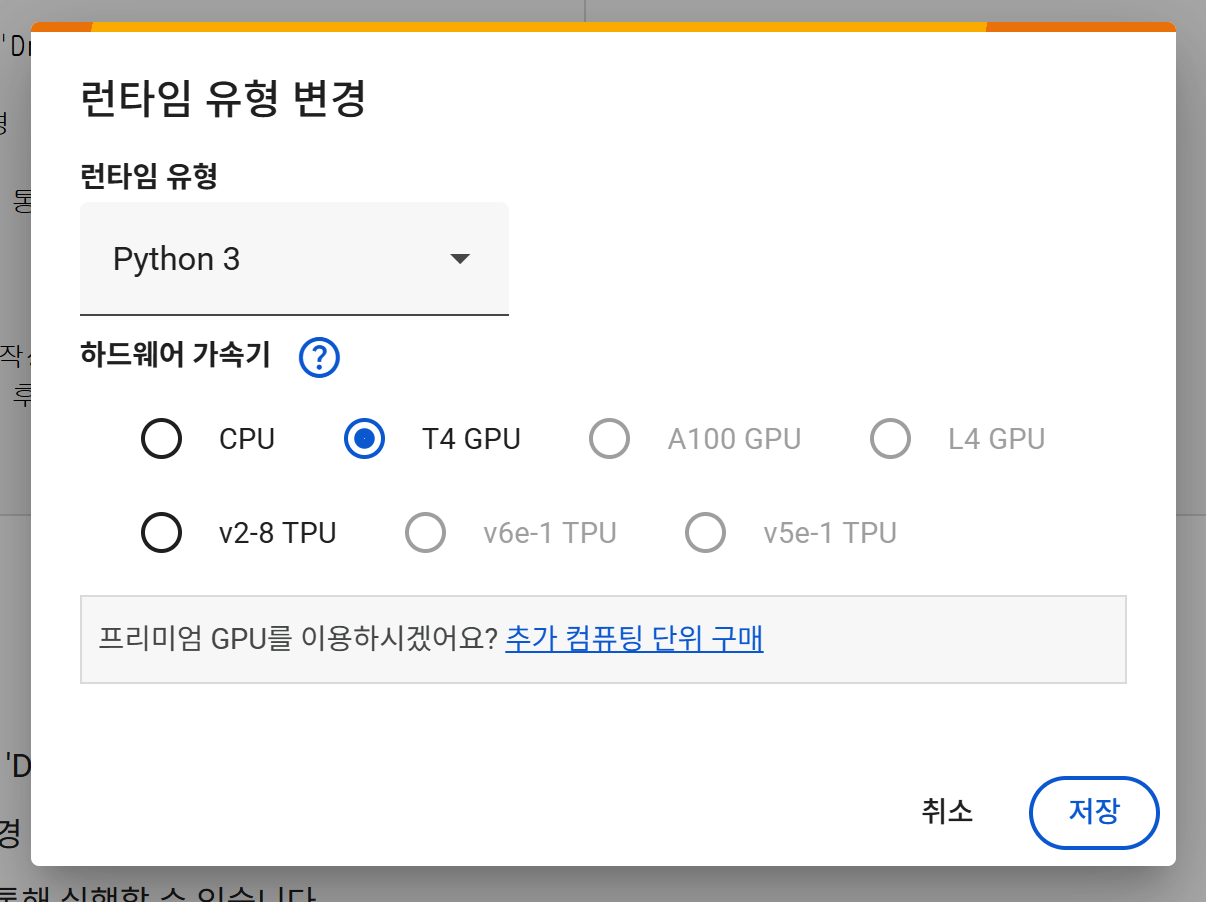

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

※ 본 실습 참고 자료: 핸즈온 LLM

# 표현형 모델을 활용하여 분류 모델 만들기

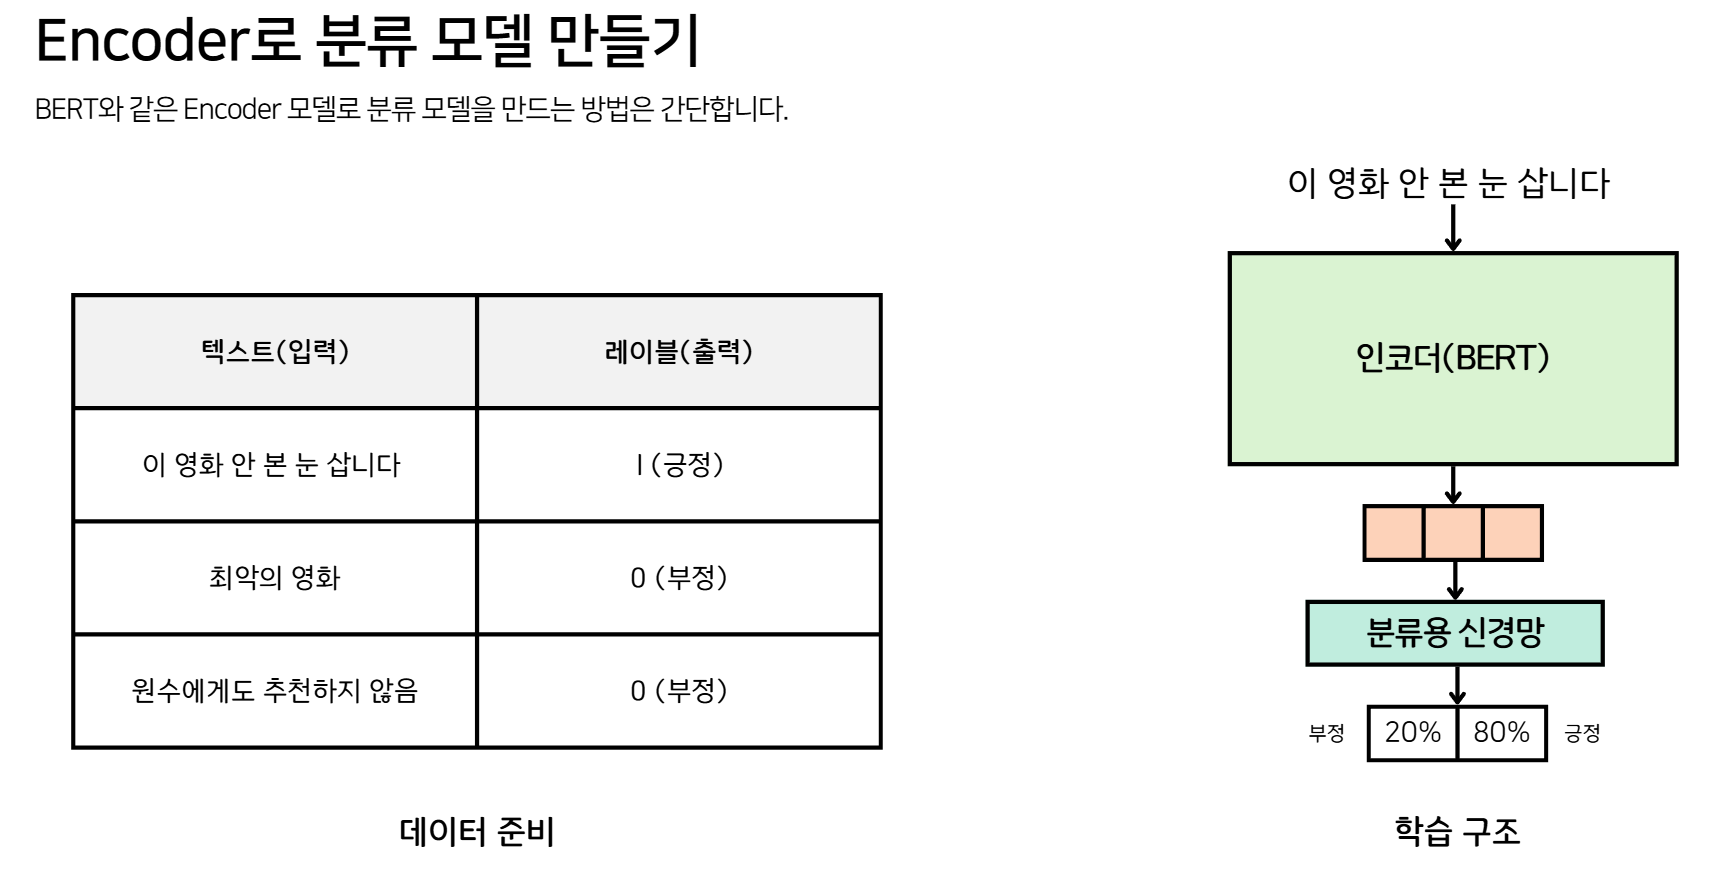

## 데이터 로드

In [1]:
from datasets import load_dataset
import random

# 데이터를 준비하고 분할합니다.
# 네이버 영화 리뷰 데이터
naver_movie = load_dataset("Blpeng/nsmc")
train_data, test_data = naver_movie["train"], naver_movie["test"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


ratings_train.csv:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

ratings_test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [72]:
random_data = train_data.shuffle().select([1])
print(random_data['document'][0])
print("긍정" if random_data['label'][0] ==1 else "부정")

견자단의 엽문은 겸손까지 갖추고 무수히 많은 명언을 만들어내는 상상초월 완벽남.
긍정


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 모델과 토크나이저를 로드합니다.
model_id = "google-bert/bert-base-multilingual-uncased" # 한글 지원 가능 BERT
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [3]:
# 시간 관계상 일부 데이터만 샘플링 해서 사용합니다.
train_data_sampled = train_data.shuffle(seed=42).select(range(10000))
test_data_sampled = test_data.shuffle(seed=42).select(range(1000))

In [4]:
# 비어있는 데이터 제거
train_data_sampled = train_data_sampled.filter(lambda example: example["document"] is not None and len(example["document"]) > 0)
test_data_sampled = test_data_sampled.filter(lambda example: example["document"] is not None and len(example["document"]) > 0)

print("Filtered train_data length:", len(train_data_sampled))
print("Filtered test_data length:", len(test_data_sampled))

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filtered train_data length: 10000
Filtered test_data length: 1000


In [5]:
# 학습을 하기 전 미리 Tokenization
def preprocess_function(examples):
   """입력 데이터를 토큰으로 나눕니다"""
   # Tokenize each document in the batch
   return tokenizer(examples["document"], truncation=True)

# 훈련 데이터와 테스트 데이터를 토큰화합니다.
tokenized_train = train_data_sampled.map(preprocess_function, batched=True)
tokenized_test = test_data_sampled.map(preprocess_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
from transformers import DataCollatorWithPadding

# 배치에서 가장 긴 시퀀스에 맞춰 패딩합니다.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
! pip install evaluate

import numpy as np
import evaluate
# 평가 방
def compute_metrics(eval_pred):
    """F1 점수를 계산합니다"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00


## 학습 시작

In [8]:
from transformers import TrainingArguments, Trainer

# 훈련 매개변수
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   logging_steps=100,
   save_strategy="epoch",
   report_to="none"
)

# 훈련 과정을 수행할 Trainer 객체
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   processing_class=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

In [9]:
# 학습 시작
trainer.train()

Step,Training Loss
500,0.558500


TrainOutput(global_step=625, training_loss=0.5426810668945312, metrics={'train_runtime': 183.0525, 'train_samples_per_second': 54.629, 'train_steps_per_second': 3.414, 'total_flos': 497600561229120.0, 'train_loss': 0.5426810668945312, 'epoch': 1.0})

In [10]:
# 평가 시작
trainer.evaluate()

{'eval_loss': 0.48993247747421265,
 'eval_f1': 0.7687564234326825,
 'eval_runtime': 6.984,
 'eval_samples_per_second': 143.184,
 'eval_steps_per_second': 9.021,
 'epoch': 1.0}

## 직접 문장을 넣어서 테스트 해보기

In [75]:
import torch.nn.functional as F
import torch

def predict_sentiment(text):
    """
    Evaluates the trained model with arbitrary text input and returns the sentiment label.

    Args:
        text (str): The input text to predict the sentiment for.

    Returns:
        str: The predicted sentiment label ("positive" or "negative").
    """
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)

    # Get predictions from the model
    with torch.no_grad():
        logits = model(**inputs).logits

    # Apply softmax to get probabilities
    probabilities = F.softmax(logits, dim=1)

    # Determine the predicted class
    predicted_class_id = torch.argmax(probabilities, dim=1).item()

    # Return the corresponding sentiment label
    return "긍정" if predicted_class_id == 1 else "부정"

In [76]:
# Example text inputs
example_texts = [
    "이 영화 정말 재미있어요!",
    "시간 낭비였어요. 최악의 영화.",
    "그냥 그래요. 특별한 감흥은 없네요.",
    "ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ",
]

# Classify each example text
for text in example_texts:
    sentiment = predict_sentiment(text)
    print(f"Input: '{text}' -> Predicted sentiment: {sentiment}")

Input: '이 영화 정말 재미있어요!' -> Predicted sentiment: 긍정
Input: '시간 낭비였어요. 최악의 영화.' -> Predicted sentiment: 부정
Input: '그냥 그래요. 특별한 감흥은 없네요.' -> Predicted sentiment: 부정
Input: 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ' -> Predicted sentiment: 긍정


# 새로운 데이터로 똑같이 시도해보기

데이터셋 요약: 한국어 풍자(비꼼) 데이터셋은 문장의 원래 의미를 크게 바꿀 수 있는 텍스트 내 풍자를 감지하기 위해 만들어졌습니다. 트위터에서 9,319개의 트윗을 수집하여 풍자(1) 또는 비풍자(2)로 분류했습니다. 이 트윗들은 "irony sarcastic", "irony sarcastic", "sarcasm"을 쿼리하여 수집되었습니다. 익명성을 유지하기 위해 키워드 해시태그, URL, 사용자 멘션을 제거하는 전처리 과정을 거쳤습니다.

https://huggingface.co/datasets/SpellOnYou/kor_sarcasm

In [119]:
new_data = load_dataset("SpellOnYou/kor_sarcasm")

In [120]:
new_data

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 301
    })
})

In [129]:
random_data = new_data['train'].shuffle().select([1])
print(random_data['tokens'][0])
print("풍자" if random_data['label'][0] == 1 else "평문")

@user Tania 씨 살이 좀 찌셨어요 ? 잘 어울리세요 , 훨씬 더 건강하게 보여요 .  haha
풍자
